# Custom model objects

Here we will go over some of the core functionality of AstroPhot models so that you can make your own custom models with arbitrary behavior. This is an advanced tutorial and likely not needed for most users. However, the flexibility of AstroPhot can be a real lifesaver for some niche applications! If you get stuck trying to make your own models, please contact Connor Stone (see GitHub), he can help you get the model working and maybe even help add it to the core AstroPhot model list!

### AstroPhot model hierarchy

AstroPhot models are very much object oriented and inheritence driven. Every AstroPhot model inherits from `AstroPhot_Model` and so if you wish to make something truly original then this is where you would need to start. However, it is almost certain that is the wrong way to go. Further down the hierarchy is the `Component_Model` object, this is what you will likely use to construct a custom model as it represents a single "unit" in the astronomical image. Spline, Sersic, Exponential, Gaussian, PSF, Sky, etc. all of these inherit from `Component_Model` so likely that's what you will want. At its core, a `Component_Model` object defines a center location for the model, but it doesn't know anything else yet. At the same level as `Component_Model` is `Group_Model` which represents a collection of model objects (typically but not always `Component_Model` objects). A `Group_Model` is how you construct more complex models by composing several simpler models. It's unlikely you'll need to inherit from `Group_Model` so we won't discuss this any further (contact the developers if you're thinking about that). 

Inheriting from `Component_Model` are a few general classes which make it easier to build typical cases. There is the `Galaxy_Model` which adds a position angle and axis ratio to the model; also `Star_Model` which simply enforces no psf convolution on the object since that will be handled internally for anything star like; `Sky_Model` should be used for anything low resolution defined over the entire image, in this model psf convolution and integration are turned off since they shouldn't be needed. Based on these low level classes, you can "jump in" where it makes sense to define your model. Of course, you can take any AstroPhot model as a starting point and modify it to suit a given task, however we will not list all models here. See the documentation for a more complete list.

### Remaking the Sersic model

Here we will remake the sersic model in AstroPhot to demonstrate how new models can be created

In [1]:
import astrophot as ap
import torch
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
ap.AP_config.set_logging_output(stdout = True, filename = None) # see GettingStarted tutorial for what this does

In [2]:
class My_Sersic(ap.models.Galaxy_Model):
    """Let's make a sersic model!
    """
    
    model_type = f"mysersic {ap.models.Galaxy_Model.model_type}" # here we give a name to the model, the convention is to lead with a new identifier then include the name of the inheritance model
    parameter_specs = {
        "my_n": {"limits": (0.36,8)}, # our sersic index will have some default limits so it doesn't produce weird results
        "my_Re": {"limits": (0,None)}, # our effective radius must be positive, otherwise it is fair game
        "my_Ie": {}, # our effective surface density could be any real number
    }
    _parameter_order = ap.models.Galaxy_Model._parameter_order + ("my_n", "my_Re", "my_Ie") # we have to tell AstroPhot what order to access these parameters, this is used in several underlying methods
    
    def radial_model(self, R, image = None, parameters = None): # by default a Galaxy_Model object will call radial_model to determine the flux at each pixel
        bn = ap.utils.conversions.functions.sersic_n_to_b(parameters["my_n"].value) # AstroPhot has a number of useful util functions, though you are welcome to use your own
        return parameters["my_Ie"].value * (image.pixel_area) * torch.exp(-bn * ((R / parameters["my_Re"].value)**(1. / parameters["my_n"].value) - 1)) # this is simply the classic sersic profile. more details later.

Now lets try optimizing our sersic model on some data. We'll use the same galaxy from the GettingStarted tutorial. The results should be about the same!

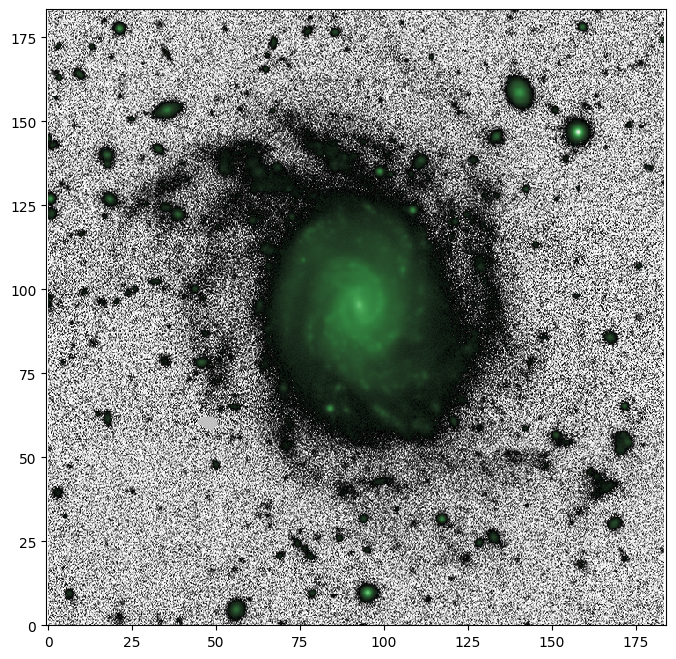

In [3]:
hdu = fits.open("https://www.legacysurvey.org/viewer/fits-cutout?ra=36.3684&dec=-25.6389&size=700&layer=ls-dr9&pixscale=0.262&bands=r")
target_data = np.array(hdu[0].data, dtype = np.float64)

# Create a target object with specified pixelscale and zeropoint
target = ap.image.Target_Image(
    data = target_data,
    pixelscale = 0.262, 
    zeropoint = 22.5,
    variance = np.ones(target_data.shape)/1e3,
)

# The default AstroPhot target plotting method uses log scaling in bright areas and histogram scaling in faint areas
fig, ax = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig, ax, target)
plt.show()

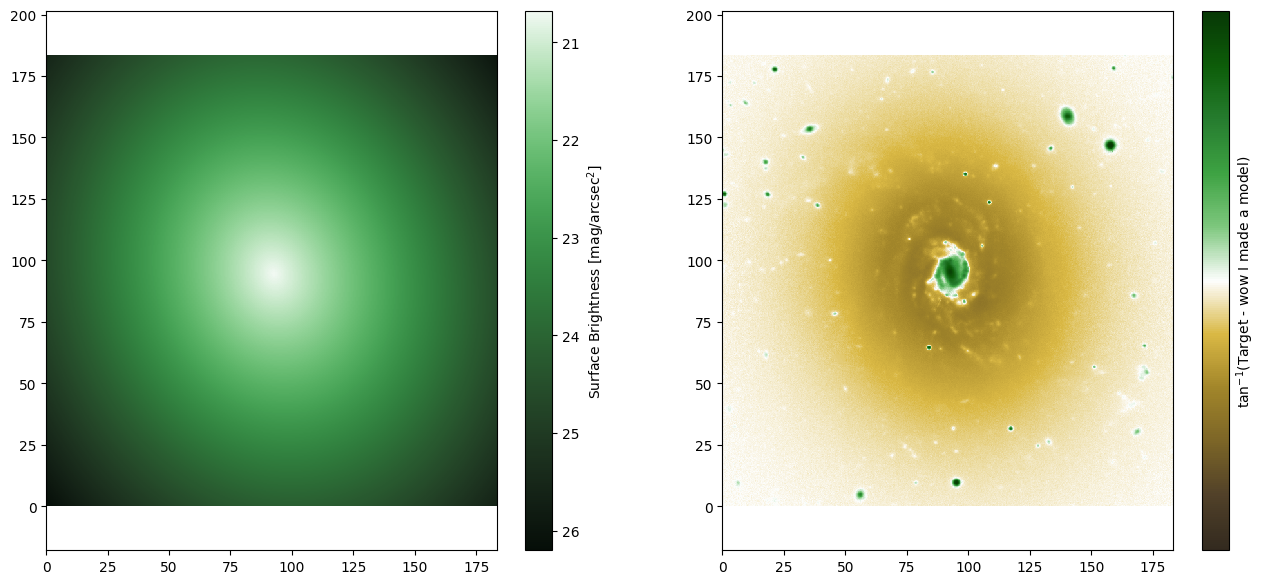

In [4]:
my_model = My_Sersic( # notice we are now using the custom class
    name = "wow I made a model", 
    target = target, # now the model knows what its trying to match
    parameters = {"my_n": 1., "my_Re": 50, "my_Ie": 1.}, # note we have to give initial values for our new parameters. We'll see what can be done for this later
)

# We gave it parameters for our new variables, but initialize will get starting values for everything else
my_model.initialize()

# The starting point for this model is not very good, lets see what the optimizer can do!
fig, ax = plt.subplots(1, 2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], my_model)
ap.plots.residual_image(fig, ax[1], my_model)
plt.show()

In [5]:
result = ap.fit.LM(my_model, verbose = 1).fit()
print(result.message)

Chi^2: 7.109751803125161, L: 1.0
Chi^2: 5.143670227723925, L: 0.3333333333333333
Chi^2: 4.677015048085209, L: 0.5555555555555555
Chi^2: 4.386867017322607, L: 0.061728395061728385
Chi^2: 4.325237897975575, L: 0.020576131687242795
Chi^2: 4.316183355875316, L: 0.006858710562414265
Chi^2: 4.312889741481864, L: 9.408382115794602e-06
Chi^2: 4.312870603174882, L: 1.2905873958565983e-08
Final Chi^2: 4.312869652476857, L: 1.2905873958565983e-08. Converged: success
success


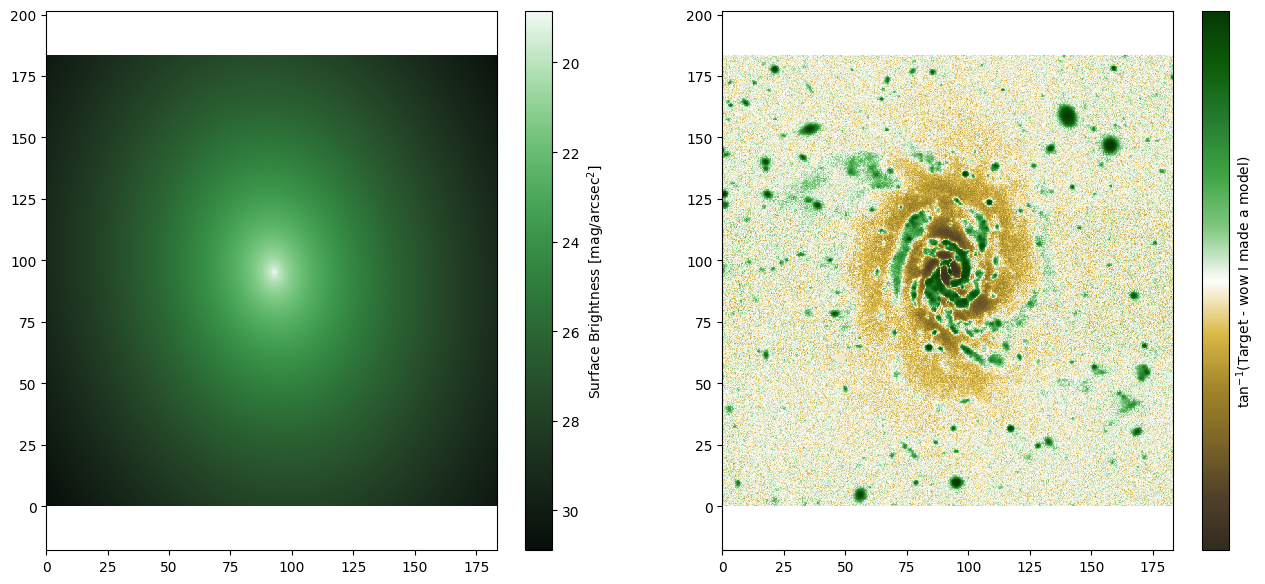

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], my_model)
ap.plots.residual_image(fig, ax[1], my_model)
plt.show()

Success! Our "custom" sersic model behaves exactly as expected. While going through the tutorial so far there may have been a few things that stood out to you. Lets discuss them now:

- What was "sample_image" in the radial_model function? This is an object for the image that we are currently sampling. You shouldn't need to do anything with it except get the pixelscale.
- what else is in "ap.utils"? Lots of stuff used in the background by AstroPhot. For now the organization of these is not very good and sometimes changes, so you may wish to just make your own functions for the time being.
- Why the weird way to access the parameters? The self\["variable"\].value format was settled on for simplicity and generality. it's not perfect, but it works.
- Why is "sample_image.pixel_area" in the sersic evaluation? it is important for AstroPhot to know the size of the pixels it is evaluating, multiplying by this value will normalize the flux evaluation regardless of the pixel sizes.
- When making the model, why did we have to provide values for the parameters? Every model can define an "initialize" function which sets the values for its parameters. Since we didn't add that function to our custom class, it doesn't know how to set those variables. All the other variables can be auto-initialized though.

### Adding an initialize method

Here we'll add an initialize method. Though for simplicity we wont make it very clever. It will be up to you to figure out the best way to start your parameters. The initial values can have a huge impact on how well the model converges to the solution, so don't underestimate the gains that can be made by thinking a bit about how to do this right. The default AstroPhot methods have reasonably robust intiializers, but still nothing beats trial and error by eye to get started. 

In [7]:
class My_Super_Sersic(My_Sersic): # note we're inheriting everything from the My_Sersic model since its not making any new parameters
    model_type = "super awesome sersic model" # you can make the name anything you like, but the one above follows the normal convention
    
    def initialize(self,target = None, parameters = None):
        if target is None: # good to just use the model target if none given
            target = self.target
        if parameters is None:
            parameters = self.parameters
        super().initialize(target=target, parameters=parameters) # typically you want all the lower level parameters determined first
        
        target_area = target[self.window] # this gets the part of the image that the user actually wants us to analyze
        
        if self["my_n"].value is None: # only do anything if the user didn't provide a value
            parameters["my_n"].set_value(2., override_locked = True) # make an initial value for my_n. Override locked since this is the beginning
            parameters["my_n"].set_uncertainty(0.1, override_locked = True) # make sure there is a starting point for the uncertainty too

        if self["my_Re"].value is None: # same as my_n, though in general you should try to do something smart to get a good starting point
            parameters["my_Re"].set_value(20., override_locked = True)
            parameters["my_Re"].set_uncertainty(0.1, override_locked = True) 

        if self["my_Ie"].value is None: # lets try to be a bit clever here
            small_window = self.window.copy().crop_pixel((250,)) # This creates a window much smaller, but still centered on the same point
            parameters["my_Ie"].set_value(torch.median(target_area[small_window].data)/target_area.pixel_area, override_locked = True) # this will be an average in the window, should at least get us within an order of magnitude
            parameters["my_Ie"].set_uncertainty(0.1, override_locked = True) 

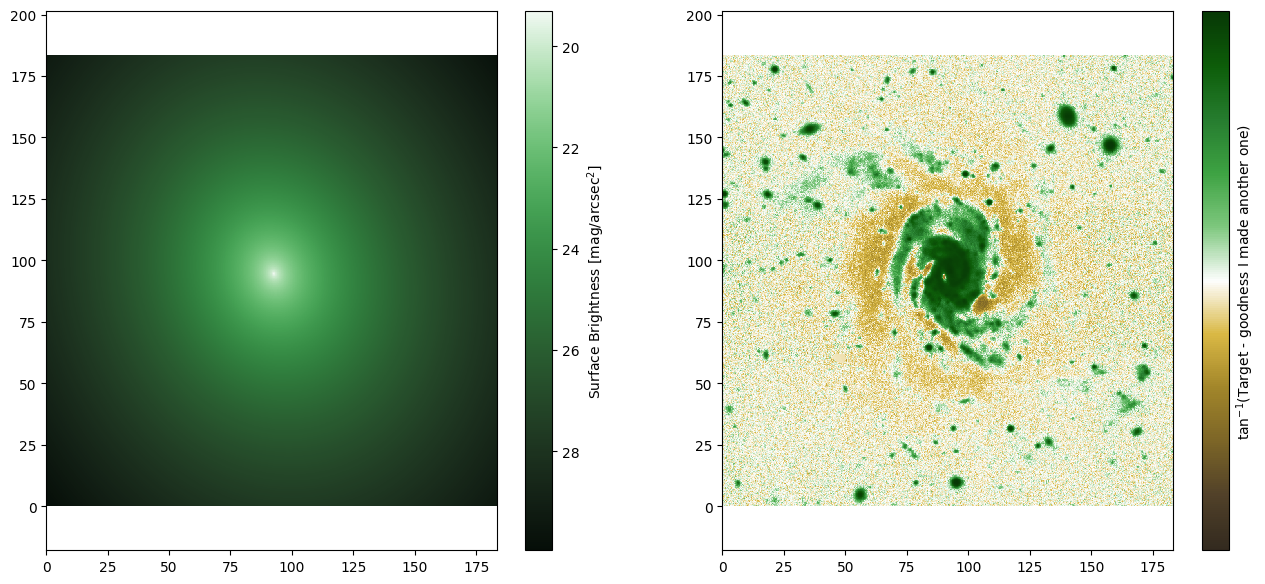

In [8]:
my_super_model = My_Super_Sersic( # notice we switched the custom class
    name = "goodness I made another one", 
    target = target, 
) # no longer need to provide initial values!

my_super_model.initialize()

# The starting point for this model is still not very good, lets see what the optimizer can do!
fig, ax = plt.subplots(1, 2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], my_super_model)
ap.plots.residual_image(fig, ax[1], my_super_model)
plt.show()

In [9]:
# We made a "good" intializer so this should be faster to optimize
result = ap.fit.LM(my_super_model, verbose = 1).fit()
print(result.message)

Chi^2: 4.574760627366948, L: 1.0
Chi^2: 4.345196325012147, L: 0.1111111111111111
Chi^2: 4.319115192915041, L: 0.037037037037037035
Chi^2: 4.3178123356351525, L: 0.012345679012345678
Chi^2: 4.312918310107078, L: 1.693508780843029e-05
Chi^2: 4.312871944101159, L: 2.323057312541878e-08
Chi^2: 4.312869691068914, L: 7.743524375139593e-09
Final Chi^2: 4.312869609777904, L: 7.743524375139593e-09. Converged: success
success


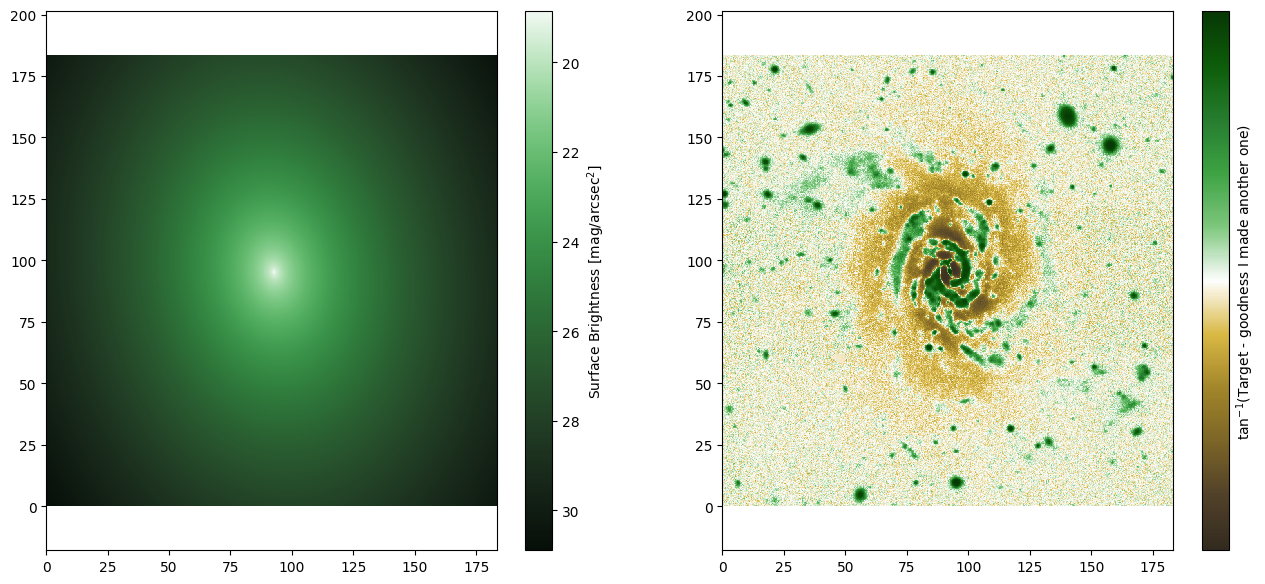

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], my_super_model)
ap.plots.residual_image(fig, ax[1], my_super_model)
plt.show()

Success! That covers the basics of making your own models. There's an infinite amount of possibility here so you will likely need to hunt through the AstroPhot code to find answers to more nuanced questions (or contact Connor), but hopefully this tutorial gave you a flavour of what to expect.

## Models from scratch

By inheriting from `Galaxy_Model` we got to start with some methods already available. In this section we will see how to create a model essentially from scratch by inheriting from the `Component_Model` object. Below is an example model which uses a $\frac{I_0}{R}$ model, this is a weird model but it will work. To demonstrate the basics for a `Component_Model` is actually simpler than a `Galaxy_Model` we really only need the `evaluate_model` function, it's what you do with that function where the complexity arises.

In [11]:
class My_InvR(ap.models.Component_Model):
    model_type = "InvR model"
    
    parameter_specs = {
        "my_Rs": {"limits": (0,None)}, # This will be the scale length
        "my_I0": {}, # This will be the central brightness
    }
    _parameter_order = ap.models.Component_Model._parameter_order + ("my_Rs", "my_I0") # we have to tell AstroPhot what order to access these parameters, this is used in several underlying methods

    epsilon = 1e-4 # this can be set with model.epsilon, but will not be fit during optimization
    def evaluate_model(self, X = None, Y = None, image = None, parameters = None):
        if X is None or Y is None:
            Coords = image.get_coordinate_meshgrid()
            X, Y = Coords - parameters["center"].value[...,None,None]
        return parameters["my_I0"].value * image.pixel_area / torch.sqrt(X**2 + Y**2 + self.epsilon)

See now that we must define a `evaluate_model` method. This takes coordinates, an image object, and parameters and returns the model evaluated at the coordinates. No need to worry about integrating the model within a pixel, this will be handled internally, just evaluate the model at the center of each pixel. For most situations this is made easier with the `get_coordinate_meshgrid_torch` method that all AstroPhot `Target_Image` objects have. We also add a new value `epsilon` which is a core radius in arcsec. This parameter will not be fit, it is set as part of the model creation. You can now also provide epsilon when creating the model, or do nothing and the default value will be used.

From here you have complete freedom, it need only provide a value for each pixel in the given image. Just make sure that it accounts for pixel size (proportional to pixelscale^2). Also make sure to use only pytorch functions, since that way it is possible to run on GPU and propogate derivatives.

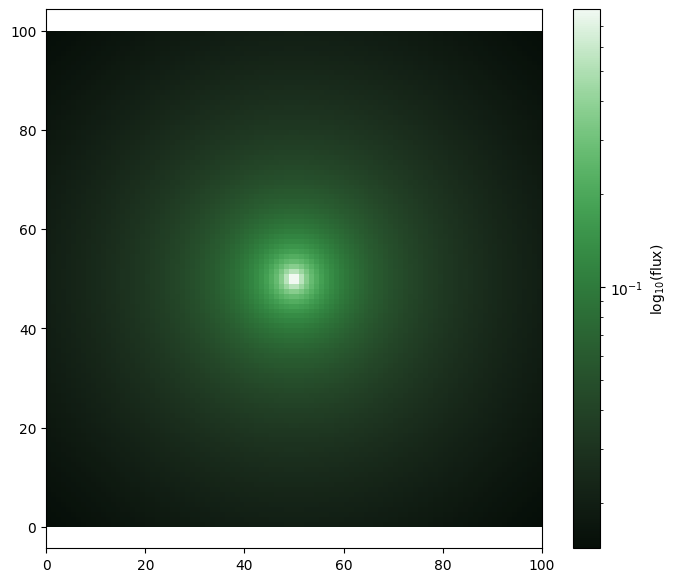

In [12]:
simpletarget = ap.image.Target_Image(data = np.zeros([100,100]), pixelscale = 1)
newmodel = My_InvR(name = "newmodel", epsilon = 1, parameters = {"center": [50,50], "my_Rs": 10, "my_I0": 1.}, target = simpletarget)

fig, ax = plt.subplots(1, 1, figsize = (8,7))
ap.plots.model_image(fig, ax, newmodel)
plt.show()